 <h1 style="font-family:verdana;"> <center>OpenAI GPT2🔥FINETUNING WITH PYTORCH  </center> </h1>

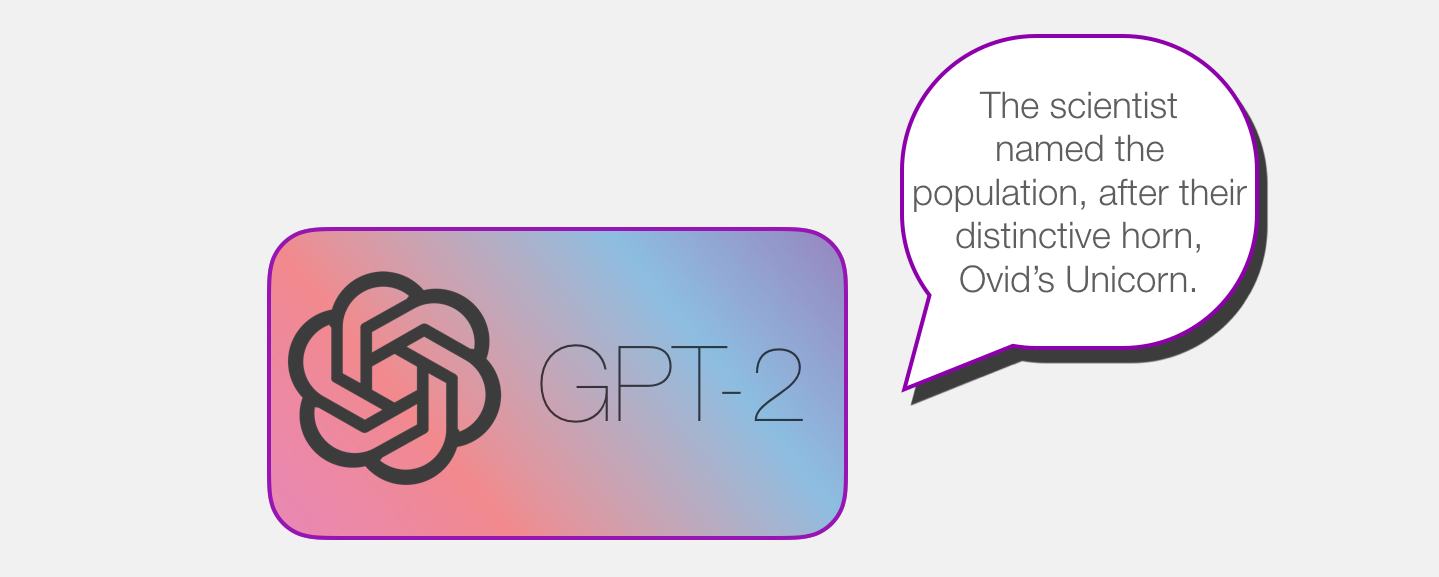

ABSTRACT FROM THE PAPER:  [Language Models are Unsupervised Multitask Learners](https://d4mucfpksywv.cloudfront.net/better-language-models/language-models.pdf)
> 
> Natural language processing tasks, such as question answering, machine translation, reading comprehension, and summarization, are typically approached with supervised learning on taskspecific datasets. We demonstrate that language models begin to learn these tasks without any explicit supervision when trained on a new dataset of millions of webpages called WebText. When conditioned on a document plus questions, the answers generated by the language model reach 55 F1 on the CoQA dataset - matching or exceeding the performance of 3 out of 4 baseline systems without using the 127,000+ training examples.
> The capacity of the language model is essential to the success of zero-shot task transfer and increasing it improves performance in a log-linear fashion across tasks. Our largest model, **GPT-2**,is a 1.5B parameter Transformer that achieves
> state of the art results on 7 out of 8 tested language modeling datasets in a zero-shot setting
> but still underfits WebText. Samples from the model reflect these improvements and contain coherent paragraphs of text. These findings suggest a promising path towards building language processing systems which learn to perform tasks from
> their naturally occurring demonstrations.
> 

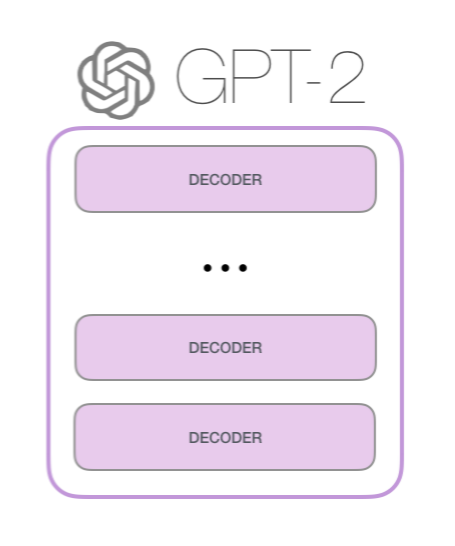

# LET'S START


<p style="color:#159364; font-family:cursive;">INSTALL THE TRANSFORMERS PACKAGE FROM THE HUGGING FACE LIBRARY</center></p>


In [ ]:
!pip install transformers

# <p style="color:#159364; font-family:cursive;">IMPORT THE LIBRARIES</center></p>

In [ ]:
import os
import gc
import copy
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import transformers
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from collections import defaultdict
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
import warnings
warnings.filterwarnings("ignore")


# <p style="color:#159364; font-family:cursive;">LOOK AT THE DATA</center></p>

In [ ]:
df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv",usecols=["id","excerpt"])
print('Number of training sentences: {:,}\n'.format(df.shape[0]))
df.sample(10)

# <p style="color:#159364; font-family:cursive;">A BIT OF PREPROCESSING</center></p>

In [ ]:
def prep_text(text_df):
    text_df = text_df.str.replace("\n","",regex=False) 
    return text_df.str.replace("\'s",r"s",regex=True).values
df["excerpt"] = prep_text(df["excerpt"])
test_df["excerpt"] = prep_text(test_df["excerpt"])

# <p style="color:#159364; font-family:cursive;">CREATE FOLDS</center></p>

Code taken from:https://www.kaggle.com/abhishek/step-1-create-folds

In [ ]:
def create_folds(data, num_splits):
    # we create a new column called kfold and fill it with -1
    data["kfold"] = -1
    
    # the next step is to randomize the rows of the data
    data = data.sample(frac=1).reset_index(drop=True)

    # calculate number of bins by Sturge's rule
    # I take the floor of the value, you can also
    # just round it
    num_bins = int(np.floor(1 + np.log2(len(data))))
    
    # bin targets
    data.loc[:, "bins"] = pd.cut(
        data["target"], bins=num_bins, labels=False
    )
    
    # initiate the kfold class from model_selection module
    kf = StratifiedKFold(n_splits=num_splits)
    
    # fill the new kfold column
    # note that, instead of targets, we use bins!
    for f, (t_, v_) in enumerate(kf.split(X=data, y=data.bins.values)):
        data.loc[v_, 'kfold'] = f
    
    # drop the bins column
    data = data.drop("bins", axis=1)

    # return dataframe with folds
    return data


# create folds
df = create_folds(df, num_splits=5)

# <p style="color:#159364; font-family:cursive;">TRAINING CONFIGURATION</center></p>

In [ ]:
class CONFIG:
    seed = 120
    max_len = 305
    train_batch = 16
    valid_batch = 16
    epochs = 10
    learning_rate = 2e-5
    splits = 5
    n_labels=1
    scaler = amp.GradScaler()
    model='gpt2'
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>')
    # default to left padding
    tokenizer.padding_side = "left"
    # Define PAD Token = EOS Token = 50256
    tokenizer.pad_token = tokenizer.eos_token
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
sen_length = []

for sentence in tqdm(df["excerpt"]):
   
    token_words = CONFIG.tokenizer.encode_plus(sentence)["input_ids"]
    sen_length.append(len(token_words))
    
print('maxlenth of all sentences are  ', max(sen_length))

# <p style="color:#159364; font-family:cursive;">REPRODUCIBILITY</center></p>

In [ ]:
def set_seed(seed = CONFIG.seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG.seed)

# <p style="color:#159364; font-family:cursive;">DEFINE THE DATASET CLASS</center></p>

* Every tensor passed to the model should be the same length.
* 
* If the text is shorter than max_length number of tokens, it will be padded to the max_length using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.
* 
* If text is longer than max_length tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
class GPT2Dataset(Dataset):
    def __init__(self,df):
        self.text = df['excerpt'].values
        self.target = df['target'].values
        self.max_len = use_tokenizer.model_max_length if CONFIG.max_len is None else CONFIG.max_len
        self.tokenizer = CONFIG.tokenizer
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=self.max_len, padding="max_length")

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'target': torch.tensor(self.target[index], dtype=torch.float)
        }

# <p style="color:#159364; font-family:cursive;">MODEL:GPT2 FOR SEQUENCE CLASSIFICATION from 🤗 </center></p>

In [ ]:
model = GPT2ForSequenceClassification.from_pretrained(
    CONFIG.model,
    num_labels = CONFIG.n_labels,
    output_attentions = False,
    output_hidden_states = False
)


# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(CONFIG.tokenizer))
# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id
# Tell pytorch to run this model on the GPU.

model.cuda()

# <p style="color:#159364; font-family:cursive;">OPTIMIZER</center></p>

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 
     'weight_decay': 0.0001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
     'weight_decay': 0.0}
    ]  
optimizer = AdamW(optimizer_parameters, lr=CONFIG.learning_rate)

# <p style="color:#159364; font-family:cursive;">GET THE PREPARED DATA</center></p>

In [ ]:
def get_data(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = GPT2Dataset(df_train)
    valid_dataset = GPT2Dataset(df_valid)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG.train_batch, 
                              num_workers=4, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG.valid_batch, 
                              num_workers=4, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

# <p style="color:#159364; font-family:cursive;">FOLD:0</center></p>

In [ ]:
train_dataloader,validation_dataloader=get_data(0)

# <p style="color:#159364; font-family:cursive;">DEFINE LOSS AND TIME FUNCTIONS</center></p>

In [ ]:
def loss_fn(output,target):
     return torch.sqrt(nn.MSELoss()(output,target))
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# <p style="color:#159364; font-family:cursive;">DEFINE THE FUNCTION FOR TRAINING,VALIDATION AND RUNNING</center></p>

In [ ]:
def run(optimizer,scheduler):
    
    scaler=CONFIG.scaler
    training_stats = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_rmse = np.inf
    total_t0 = time.time()
    epochs=CONFIG.epochs
    for epoch_i in range(0, epochs):
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        t0 = time.time()
        total_train_loss = 0
        data_size=0
        model.train()
        for step, batch in enumerate(train_dataloader):
            tr_loss=[]
            b_input_ids = batch['ids'].to(CONFIG.device)
            b_input_mask = batch['mask'].to(CONFIG.device)
            b_labels = batch['target'].to(CONFIG.device)
            batch_size = b_input_ids.size(0)
            model.zero_grad() 
            with amp.autocast(enabled=True):
                output= model(b_input_ids,labels=b_labels,attention_mask=b_input_mask,token_type_ids=None)          
                loss = output[0]
                tr_loss.append(loss.item()/len(output))
            scheduler.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        avg_train_loss = np.mean(tr_loss)    
        training_time = format_time(time.time() - t0)
        gc.collect()
        print("")
        print("  Average training loss: {0:.4f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))
        print("")
        print("Running Validation...")

        t0 = time.time()
        model.eval()
        val_loss = 0
        allpreds = []
        alltargets = []
        for batch in validation_dataloader:
            losses = []
            with torch.no_grad():
                device=CONFIG.device
                ids = batch["ids"].to(device)
                mask = batch["mask"].to(device)
                target = batch["target"].to(device)
                output= model(ids,labels=target,attention_mask=mask,token_type_ids=None) 
                loss = output[0]
                losses.append(loss.item()/len(output))
                allpreds.append(output[1].detach().cpu().numpy())
                alltargets.append(target.detach().squeeze(-1).cpu().numpy())
        allpreds = np.concatenate(allpreds)
        alltargets = np.concatenate(alltargets)
        val_rmse=mean_squared_error(alltargets, allpreds, squared=False)
        losses = np.mean(losses)
        gc.collect() 
        validation_time = format_time(time.time() - t0)
        print("  Validation Loss: {0:.4f}".format(losses))
        print("  Validation took: {:}".format(validation_time))
        if val_rmse <= best_rmse:
            print(f"Validation RMSE Improved ({best_rmse} -> {val_rmse})")
            best_rmse = val_rmse
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = "rmse{:.4f}_epoch{:.0f}.bin".format(best_rmse, epoch_i)
            torch.save(model.state_dict(), PATH)
            print("Model Saved")
        training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': losses,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    ) 
    print("")
    print("Training complete!")
    return training_stats  

# <p style="color:#159364; font-family:cursive;">VISUALIZATION FUNCTION </center></p>

In [ ]:
def Visualizations(training_stats):
    pd.set_option('precision', 4)
    df_stats = pd.DataFrame(data=training_stats)
    df_stats = df_stats.set_index('epoch')
    layout = go.Layout(template= "plotly_dark",title='GPT2 loss curve')
    fig = go.Figure(layout=layout)
    fig.add_trace(go.Scatter(x=df_stats.index, y=df_stats['Training Loss'],
                    mode='lines+markers',
                    name='Training Loss'))
    fig.add_trace(go.Scatter(x=df_stats.index, y=df_stats['Valid. Loss'],
                    mode='lines+markers',
                    name='Validation Loss'))
    fig.show()

# <p style="color:#159364; font-family:cursive;">LEARNING RATE SCHEDULER </center></p>

**LINEAR SCHEDULE WITH WARMUP**

In [ ]:
# Defining LR Scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=len(train_dataloader)*CONFIG.epochs
)
lrs = []
for epoch in range(1, CONFIG.epochs + 1):
    if scheduler is not None:
        scheduler.step()
    lrs.append(optimizer.param_groups[0]["lr"])
layout = go.Layout(template= "plotly_dark",title='Learning_rate')
fig = go.Figure(layout=layout)

fig.add_trace(go.Scatter(x=list(range(10)), y=lrs,
                    mode='lines+markers',
                    name='Learning_rate'))
fig.show()

**RUN ON THE SET SCHEDULER**

In [ ]:
df1=run(optimizer,scheduler)

In [ ]:
Visualizations(df1)

![Upvote!](https://img.shields.io/badge/Upvote-If%20you%20like%20my%20work-07b3c8?style=for-the-badge&logo=kaggle)